# HW5: Option Pricing with Hull White Model

## Overview
1. 透過 Monte Carlo method
    1. 對 Hull White Model 模擬 Short Rate
    2. 將 Short Rate 帶入 Geometric Brownian Motion，r 換成 r(t) 模擬股價
    3. 自訂選擇權履約價，對每一條 path 計算出到期日時的 PayOff
2. 對所有 Path 的 PayOff 進行期望值計算，並折現回 t=0 的時間點
3. 計算出 Call Price & Put Price

## Step 1: Hull White Model ([ref](http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html))

In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sigma = 0.1
a = 0.1
length = 1
timestep = length * 360                       
forward_rate = 0.05
day_count = ql.Thirty360()
todays_date = ql.Date(12, 5, 2020)

T = timestep
num_paths = 100
dt = 0.01                  
S0 = 100
K = 105
r = 0.01

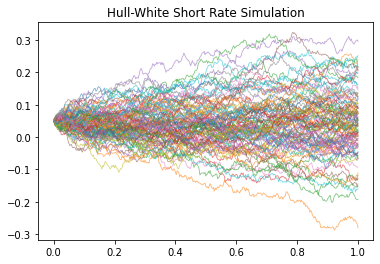

In [3]:
ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

## Step 2: Geometric Brownian Motion ([ref](https://colab.research.google.com/drive/1LL_m1UO_U2oHDMQhBDPjhUBANDpVhev7#scrollTo=NBA3FHuhlVh9))

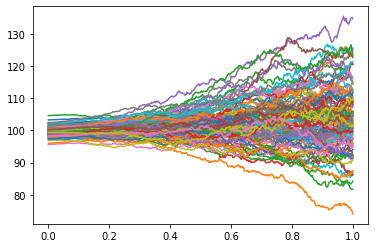

In [4]:
def genBrownPath(T, mu, sigma, S0, dt):
    S = []
    W = [0] + np.random.standard_normal(size = 1) 
    W = (W + np.random.standard_normal(size = 1))*np.sqrt(dt)
    for i in range(len(time)):
        S.append(S0*np.exp((float(mu[i])-0.5*sigma**2)*float(time[i]) + sigma*W)) 
    plt.plot(time, S)
    return S

paths_2 = []
for i in range(num_paths-1):
    paths_2.append(genBrownPath(T, paths[i], sigma, S0, dt))

## Step 3: Call Price & Put Price

In [5]:
call, put = [], []
for i in range(num_paths-1):
    price = paths_2[i][T]
    if price - K > 0:
        X = price - K
        call.append(X + np.exp(-1.0*r*i)*X)
    if K - price > 0:
        X = K - price
        put.append(X + np.exp(-1.0*r*i)*X)
print(f"Call Price: {np.sum(call)/num_paths}")
print(f"Put  Price: {np.sum(put)/num_paths}")

Call Price: 5.573982826334985
Put  Price: 7.386162098355205
